### Installing necessary libraries

In [182]:
# pip install --index-url=https://bloomberg.bintray.com/pip/simple blpapi 

In [183]:
#pip install blpapi-3.14.0-cp38-cp38-win_amd64.whl

In [184]:
#pip install blpapi-3.14.0-cp39-cp39-win_amd64.whl

In [185]:
#pip install xbbg

In [186]:
#pip install pdblp

In [187]:
# pip install matplotlib

In [188]:
# pip install pandas

In [189]:
# pip install numpy

### Importing libraries

In [190]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from xbbg import blp

In [191]:

# Function to flatten MultiIndex from API data (if needed)
def flatten_api_data(api_data):
    api_data.columns = api_data.columns.get_level_values(0)  # Remove 'PX_LAST' from MultiIndex
    return api_data

def load_data(ticker, start_date, end_date, use_api=False, csv_file='bloomberg_stock_data.csv'):
    """
    Load historical price data either from Bloomberg API or a CSV file.

    Parameters:
    - ticker (str): The ticker symbol for the asset (e.g., 'AAPL US Equity')
    - start_date (str): The start date for the data (e.g., '2022-01-01')
    - end_date (str): The end date for the data (e.g., '2023-01-01')
    - use_api (bool): If True, fetch data from Bloomberg API. If False, load from CSV.
    - csv_file (str): Path to the CSV file (default: 'bloomberg_stock_data.csv')

    Returns:
    - data (pd.DataFrame): DataFrame containing historical price data
    """
    if use_api:
        # Pull historical price data from Bloomberg API
        data = blp.bdh(tickers=ticker, flds=['PX_LAST'], start_date=start_date, end_date=end_date)
        # Remove multi-level index for consistency with CSV format
        data = flatten_api_data(data)
    else:
        # Load data from CSV file
        data = pd.read_csv(csv_file, skiprows=[1], parse_dates=['date'], index_col='date')
        # Filter the data by the start and end dates
        data = data.loc[start_date:end_date]
    
    return data


### Momentum strategy on single stock

In [233]:
# Define the ticker and parameters
ticker = 'AAPL US Equity'
start_date = '2020-01-01'
end_date = '2023-01-01'

# Set use_api to True for API, False for CSV
use_api = False

# Load the data
data = load_data(ticker, start_date, end_date, use_api)


In [234]:

# Calculate a simple momentum indicator (e.g., 10-day rate of change)
momentum_period = 10
data['Momentum'] = data[ticker].pct_change(periods=momentum_period)

# Generate buy/sell signals based on momentum
threshold = 0.02  # Adjust this threshold based on backtesting
data['Signal'] = 0
data.loc[data['Momentum'] > threshold, 'Signal'] = 1  # Buy signal
data.loc[data['Momentum'] < -threshold, 'Signal'] = -1  # Sell signal

# Simple strategy performance - assuming you enter a position based on signals
data['Returns'] = data[ticker].pct_change()
data['Strategy_Returns'] = data['Returns'] * data['Signal'].shift(1)

# Calculate cumulative returns of the strategy vs the asset
data['Cumulative_Strategy'] = (1 + data['Strategy_Returns']).cumprod()
data['Cumulative_Asset'] = (1 + data['Returns']).cumprod()

# Print strategy performance
data[['Momentum', 'Signal', 'Cumulative_Strategy', 'Cumulative_Asset']]


,Momentum,Signal,Cumulative_Strategy,Cumulative_Asset
date,,,,
2020-01-02,NaN,0,NaN,NaN
2020-01-03,NaN,0,1.000000,0.990278
2020-01-06,NaN,0,1.000000,0.998162
2020-01-07,NaN,0,1.000000,0.993474
2020-01-08,NaN,0,1.000000,1.009456
...,...,...,...,...
2022-12-23,-0.072454,-1,1.262585,1.756073
2022-12-27,-0.100076,-1,1.280107,1.731701
2022-12-28,-0.133567,-1,1.319388,1.678564


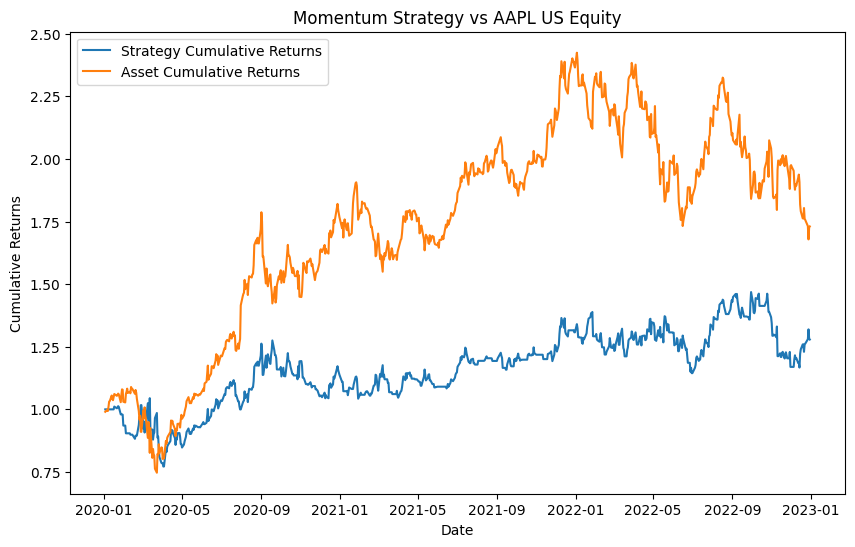

In [237]:

# Plot cumulative returns of the strategy vs the asset
plt.figure(figsize=(10, 6))

# Plot the strategy's cumulative returns
plt.plot(data.index, data['Cumulative_Strategy'], label='Strategy Cumulative Returns')

# Plot the asset's cumulative returns
plt.plot(data.index, data['Cumulative_Asset'], label='Asset Cumulative Returns')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title(f'Momentum Strategy vs {ticker}')
plt.legend()

# Show the plot
plt.show()


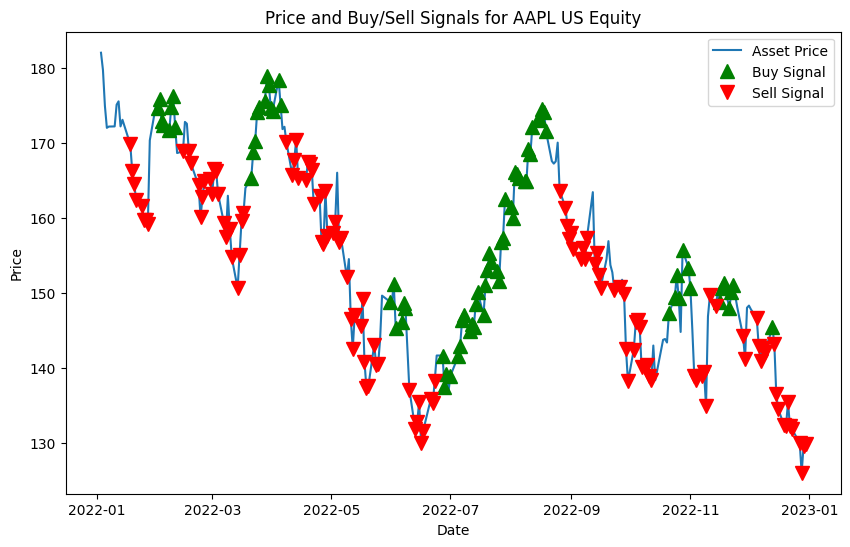

In [196]:
# Plot the asset's price along with buy/sell signals
plt.figure(figsize=(10, 6))

# Plot the price
plt.plot(data.index, data[ticker], label='Asset Price')

# Mark buy signals (green)
plt.plot(data[data['Signal'] == 1].index, data[ticker][data['Signal'] == 1], '^', markersize=10, color='g', label='Buy Signal')

# Mark sell signals (red)
plt.plot(data[data['Signal'] == -1].index, data[ticker][data['Signal'] == -1], 'v', markersize=10, color='r', label='Sell Signal')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'Price and Buy/Sell Signals for {ticker}')
plt.legend()

# Show the plot
plt.show()


### Momemtum strategy on portfolio

In [221]:

# Define your selected tickers from the WLS Index (this is just an example)
tickers = ['AAPL US Equity', 'MSFT US Equity', 'AMZN US Equity', 'NVDA US Equity', 'BRK/B US Equity', 'V US Equity']

# Define the parameters
start_date = '2010-01-01'
end_date = '2023-01-01'
momentum_period = 10
threshold = 0.02

# Load the data
data = load_data(tickers, start_date, end_date, use_api)

In [222]:
portfolio_signals = pd.DataFrame()

for ticker in tickers:
    # Access the data for each ticker directly
    stock_data = data[ticker].copy()
    
    # Calculate the momentum
    stock_data = pd.DataFrame(stock_data)  # Convert to DataFrame if it's a Series
    stock_data['Momentum'] = stock_data.pct_change(periods=momentum_period)
    
    # Generate buy/sell signals based on momentum
    stock_data['Signal'] = 0
    stock_data.loc[stock_data['Momentum'] > threshold, 'Signal'] = 1  # Buy signal
    stock_data.loc[stock_data['Momentum'] < -threshold, 'Signal'] = -1  # Sell signal

    # Store signals in the portfolio signals DataFrame
    portfolio_signals[ticker] = stock_data['Signal']

# Portfolio signals will contain buy/sell signals for all selected stocks
portfolio_signals.tail()


,AAPL US Equity,MSFT US Equity,AMZN US Equity,NVDA US Equity,BRK/B US Equity,V US Equity
date,,,,,,
2022-12-23,-1,-1,-1,-1,0,0
2022-12-27,-1,-1,-1,-1,0,-1
2022-12-28,-1,-1,-1,-1,-1,-1
2022-12-29,-1,-1,-1,-1,0,-1
2022-12-30,-1,-1,-1,-1,1,0


In [223]:
# Define initial capital and allocation (e.g., $100,000 per stock)
initial_capital = 1_000_000
allocation_per_stock = initial_capital / len(tickers)

# Track your portfolio's performance
portfolio_returns = pd.DataFrame()

for ticker in tickers:
    # Accessing the price data directly (no MultiIndex)
    stock_data = data[ticker].copy()
    
    # Calculate daily returns
    stock_data = pd.DataFrame(stock_data)  # Ensure it's a DataFrame
    stock_data['Returns'] = stock_data[ticker].pct_change()
    
    # Calculate strategy returns based on signals
    stock_data['Strategy_Returns'] = stock_data['Returns'] * portfolio_signals[ticker].shift(1)
    
    # Multiply by capital allocation
    stock_data['Allocated_Returns'] = allocation_per_stock * stock_data['Strategy_Returns']
    
    # Store in portfolio returns
    portfolio_returns[ticker] = stock_data['Allocated_Returns']

# Calculate cumulative portfolio returns
portfolio_returns['Total_Return'] = portfolio_returns.sum(axis=1).cumsum()

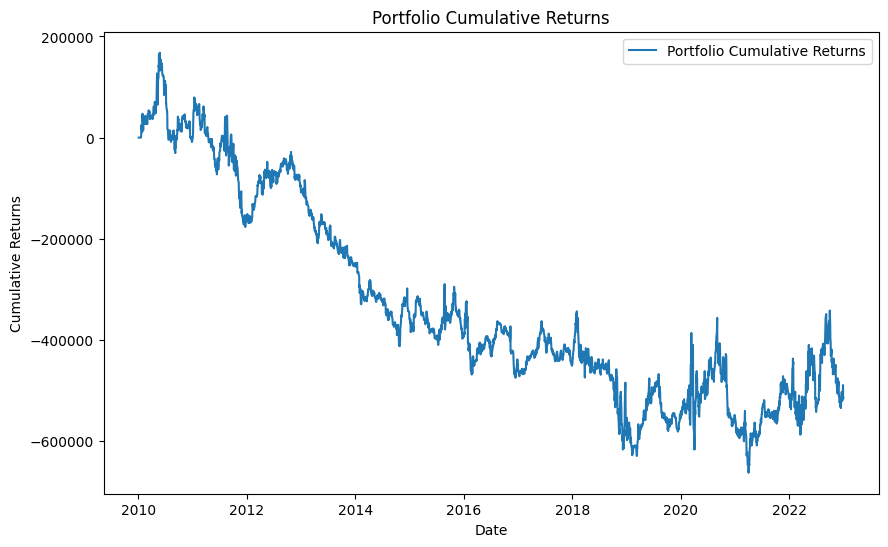

In [224]:
# Plotting the cumulative returns of the portfolio
plt.figure(figsize=(10, 6))

# Plot cumulative portfolio returns
plt.plot(portfolio_returns.index, portfolio_returns['Total_Return'], label='Portfolio Cumulative Returns')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Portfolio Cumulative Returns')
plt.legend()

# Show the plot
plt.show()

### Combining Momentum, Mean Reversion, and Volatility Strategies

In [225]:
# Define your selected tickers from the WLS Index (example)
tickers = ['AAPL US Equity', 'MSFT US Equity', 'AMZN US Equity', 'NVDA US Equity', 'BRK/B US Equity', 'V US Equity']

# Define parameters
start_date = '2010-01-01'
end_date = '2024-09-21'
momentum_period = 5  # Shortened to generate more signals
rsi_period = 10  # Loosened to make RSI conditions more responsive
bollinger_period = 15  # Shortened Bollinger period for more signals
bollinger_dev = 2  # Number of standard deviations for Bollinger Bands
volatility_threshold = 0.005  # Lowered the volatility filter threshold

# Fetch data for all tickers
data = load_data(tickers, start_date, end_date, use_api)


In [226]:

# Initialize a DataFrame to store signals for each stock
portfolio_signals = pd.DataFrame()

for ticker in tickers:
    # Access the data for each ticker directly (no 'PX_LAST')
    stock_data = data[ticker].copy()

    # Ensure the data is in a DataFrame format
    stock_data = pd.DataFrame(stock_data, columns=[ticker])
    
    # Calculate momentum (rate of change)
    stock_data['Momentum'] = stock_data[ticker].pct_change(periods=momentum_period)
    
    # Calculate RSI (mean reversion)
    delta = stock_data[ticker].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=rsi_period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=rsi_period).mean()
    rs = gain / loss
    stock_data['RSI'] = 100 - (100 / (1 + rs))

    # Calculate Bollinger Bands (for mean reversion and volatility)
    stock_data['MA20'] = stock_data[ticker].rolling(window=bollinger_period).mean()
    stock_data['STD20'] = stock_data[ticker].rolling(window=bollinger_period).std()
    stock_data['Upper_BB'] = stock_data['MA20'] + (bollinger_dev * stock_data['STD20'])
    stock_data['Lower_BB'] = stock_data['MA20'] - (bollinger_dev * stock_data['STD20'])
    
    # Calculate volatility (using ATR or Bollinger Band width as a filter)
    stock_data['BB_Width'] = stock_data['Upper_BB'] - stock_data['Lower_BB']
    stock_data['Volatility'] = stock_data['BB_Width'] / stock_data['MA20']
    
    # Generate combined signals:
    # 1. Buy if momentum is positive and RSI is below 40
    # 2. Sell if momentum is negative and RSI is above 60
    # 3. Only trade if volatility is above the threshold (volatility filter)
    
    stock_data['Signal'] = 0
    stock_data.loc[
        (stock_data['Momentum'] > 0) & (stock_data['RSI'] < 40) & (stock_data['Volatility'] > volatility_threshold),
        'Signal'
    ] = 1  # Buy signal

    stock_data.loc[
        (stock_data['Momentum'] < 0) & (stock_data['RSI'] > 60) & (stock_data['Volatility'] > volatility_threshold),
        'Signal'
    ] = -1  # Sell signal

    # Store signals in the portfolio DataFrame
    portfolio_signals[ticker] = stock_data['Signal']

# Portfolio signals will contain buy/sell signals for all selected stocks
portfolio_signals.to_csv('signals_output.csv', index=True)

# Calculate strategy performance based on signals
portfolio_returns = pd.DataFrame()

for ticker in tickers:
    stock_data = data[ticker].copy()

    # Calculate daily returns
    stock_data = pd.DataFrame(stock_data, columns=[ticker])
    stock_data['Returns'] = stock_data[ticker].pct_change()

    # Cap extreme returns to avoid spikes
    stock_data['Returns'] = stock_data['Returns'].clip(lower=-0.1, upper=0.1)  # Capping at 10%

    # Apply strategy returns based on signals
    stock_data['Strategy_Returns'] = stock_data['Returns'] * portfolio_signals[ticker].shift(1)

    # Multiply by capital allocation (for simplicity, assume equal allocation)
    stock_data['Allocated_Returns'] = (1_000_000 / len(tickers)) * stock_data['Strategy_Returns']
    
    portfolio_returns[ticker] = stock_data['Allocated_Returns']

# Calculate cumulative portfolio returns
portfolio_returns['Total_Return'] = portfolio_returns.sum(axis=1).cumsum()


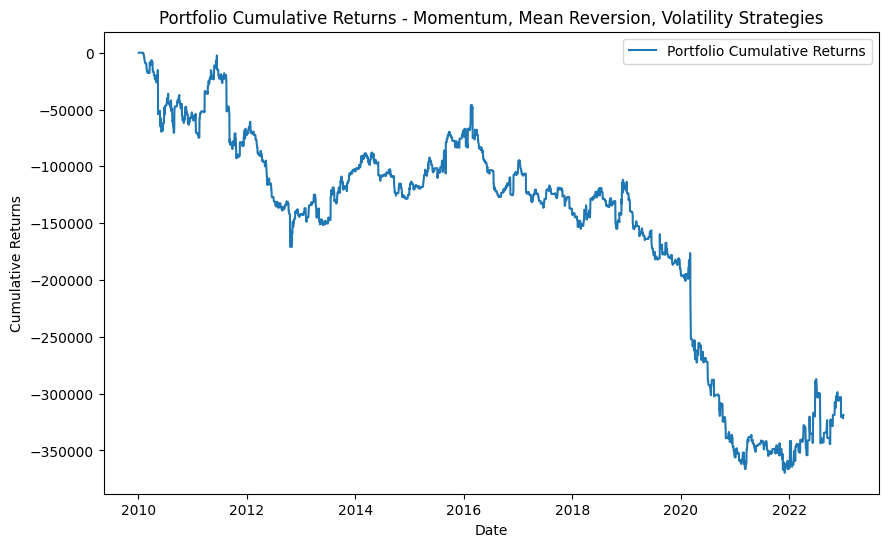

In [227]:

# Plot cumulative returns of the portfolio
plt.figure(figsize=(10, 6))
plt.plot(portfolio_returns.index, portfolio_returns['Total_Return'], label='Portfolio Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Portfolio Cumulative Returns - Momentum, Mean Reversion, Volatility Strategies')
plt.legend()
plt.show()


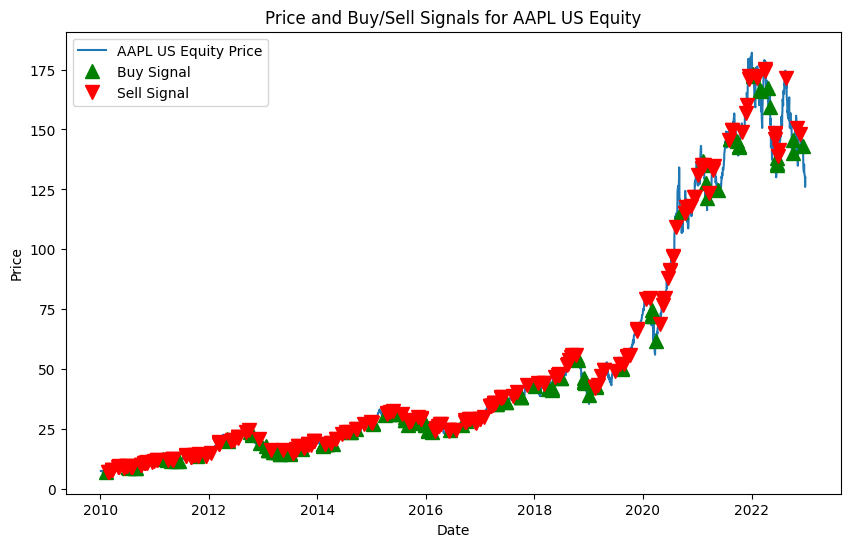

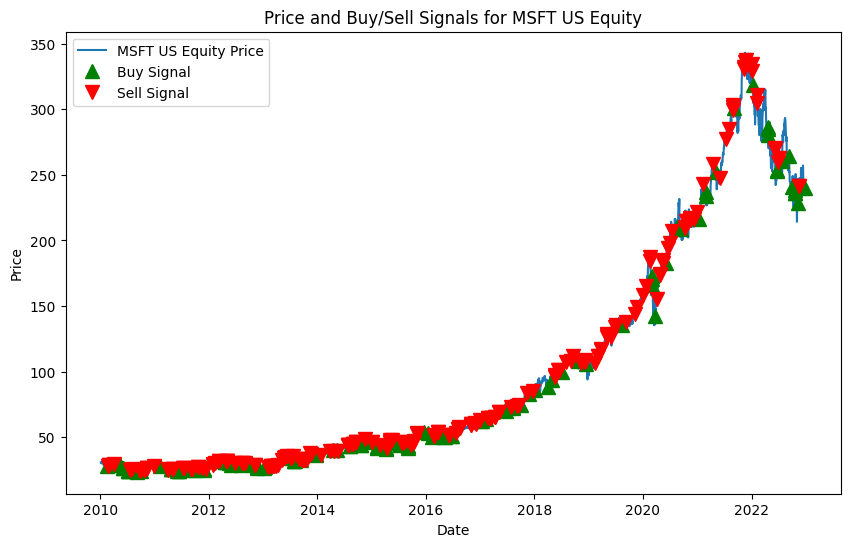

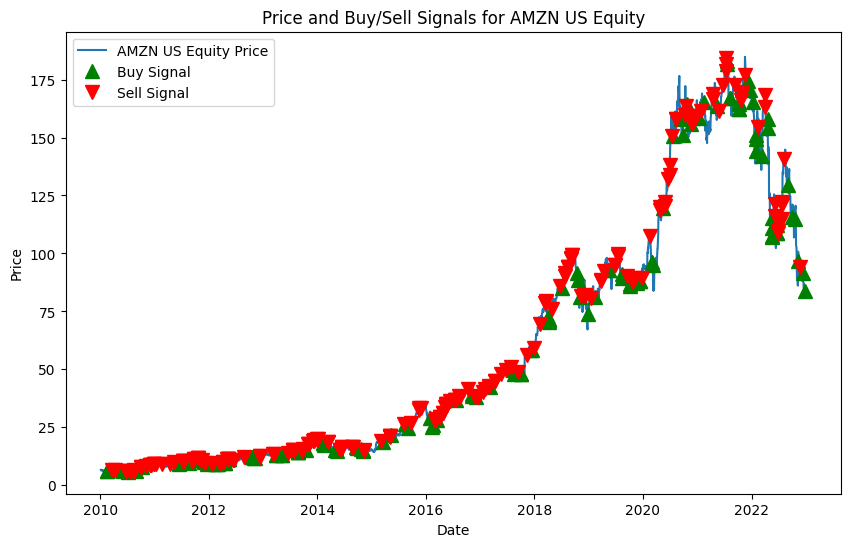

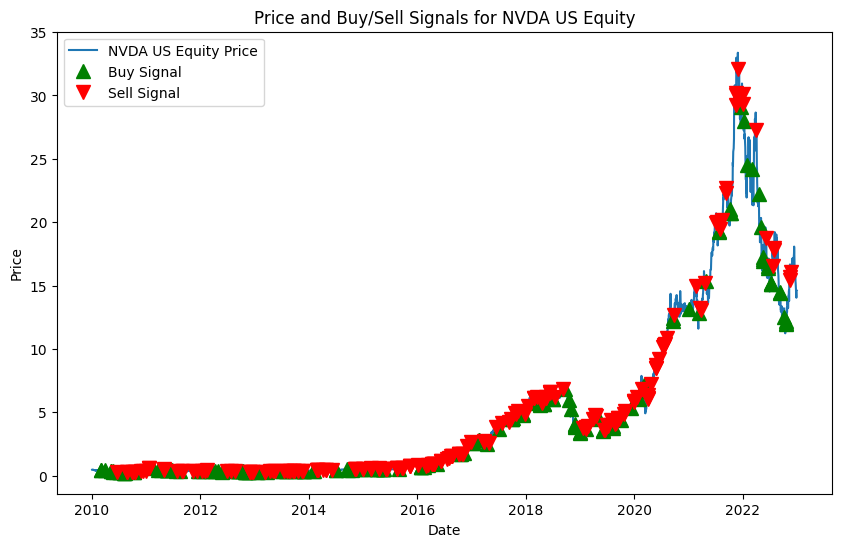

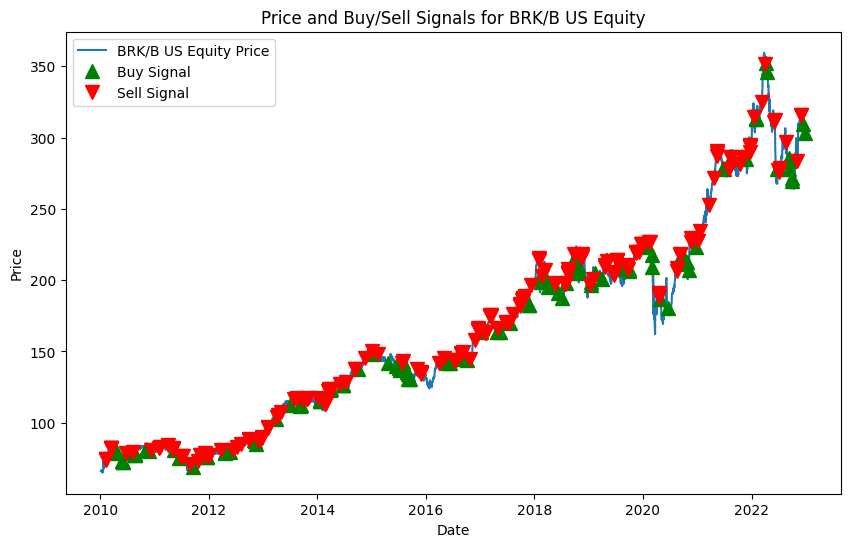

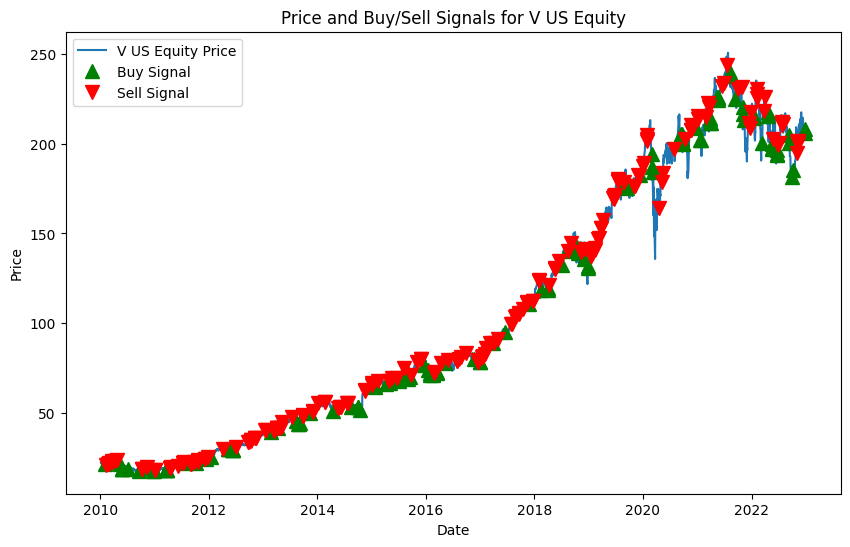

In [228]:
# Loop through each stock and plot price along with buy/sell signals
for ticker in tickers:
    stock_data = data[ticker].copy()  # Copy the stock's data

    plt.figure(figsize=(10, 6))

    # Plot the price (no 'PX_LAST', use the ticker name directly)
    plt.plot(stock_data.index, stock_data, label=f'{ticker} Price')

    # Mark buy signals (green arrows)
    plt.plot(stock_data[portfolio_signals[ticker] == 1].index, 
             stock_data[portfolio_signals[ticker] == 1], 
             '^', markersize=10, color='g', label='Buy Signal')

    # Mark sell signals (red arrows)
    plt.plot(stock_data[portfolio_signals[ticker] == -1].index, 
             stock_data[portfolio_signals[ticker] == -1], 
             'v', markersize=10, color='r', label='Sell Signal')

    # Add labels and title
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'Price and Buy/Sell Signals for {ticker}')
    plt.legend()

    # Show the plot
    plt.show()

### Random Forest to Predict Buy/Sell Signals

In [205]:
#pip install scikit-learn

In [206]:

# Define parameters
start_date = '2010-01-01'
end_date = '2024-09-21'

# Fetch data for all tickers
data = load_data(tickers, start_date, end_date, use_api)


In [207]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Define your selected tickers from the WLS Index (example)
tickers = ['AAPL US Equity', 'MSFT US Equity', 'AMZN US Equity', 'NVDA US Equity', 'BRK/B US Equity', 'V US Equity']

# DataFrame to store the cumulative returns for the random forest strategy
rf_portfolio_returns = pd.DataFrame()

# Loop over each stock and apply the Random Forest strategy
for ticker in tickers:
    stock_data = data[ticker].copy()

    # Ensure stock_data is in a DataFrame format
    stock_data = pd.DataFrame(stock_data, columns=[ticker])

    # Calculate daily returns
    stock_data['Returns'] = stock_data[ticker].pct_change()

    # Feature engineering: Momentum, Lag, and RSI
    stock_data['Momentum'] = stock_data[ticker].pct_change(periods=10)
    stock_data['Lag_1'] = stock_data[ticker].pct_change(1)
    stock_data['Lag_2'] = stock_data[ticker].pct_change(2)
    delta = stock_data[ticker].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    stock_data['RSI'] = 100 - (100 / (1 + rs))

    # Remove NaN rows
    stock_data = stock_data.dropna()

    # Create target (1 if price will go up tomorrow, 0 if down)
    stock_data['Target'] = (stock_data[ticker].shift(-1) > stock_data[ticker]).astype(int)

    # Features (X) and target (y)
    X = stock_data[['Momentum', 'Lag_1', 'Lag_2', 'RSI']]
    y = stock_data['Target']

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Train Random Forest Classifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predict on full data for buy/sell signals and add 'Predicted_Signal' to stock_data
    stock_data['Predicted_Signal'] = model.predict(X)

    # Apply predicted signals to calculate strategy returns
    stock_data['Strategy_Returns'] = stock_data['Returns'] * stock_data['Predicted_Signal'].shift(1)

    # Multiply by capital allocation (assume equal allocation across stocks)
    stock_data['Allocated_Returns'] = (1_000_000 / len(tickers)) * stock_data['Strategy_Returns']

    # Store the returns
    rf_portfolio_returns[ticker] = stock_data['Allocated_Returns']
    
# Calculate total cumulative returns for the Random Forest strategy
rf_portfolio_returns['Total_Return'] = rf_portfolio_returns.sum(axis=1).cumsum()

# Display the final cumulative returns
print(rf_portfolio_returns['Total_Return'].tail())


date
2022-12-23    1.771757e+07
2022-12-27    1.769891e+07
2022-12-28    1.769259e+07
2022-12-29    1.771444e+07
2022-12-30    1.771374e+07
Name: Total_Return, dtype: float64


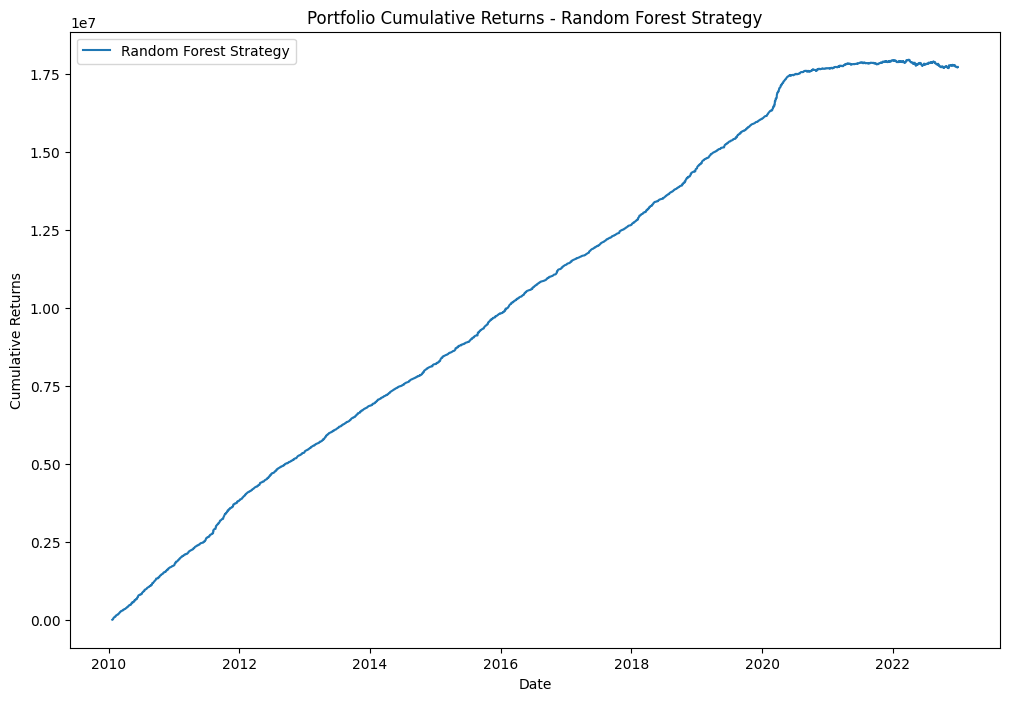

In [208]:
# Plot cumulative returns of the basic momentum strategy vs random forest strategy
plt.figure(figsize=(12, 8))

# Random Forest strategy
plt.plot(rf_portfolio_returns.index, rf_portfolio_returns['Total_Return'], label='Random Forest Strategy')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Portfolio Cumulative Returns - Random Forest Strategy')
plt.legend()

# Show the plot
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Initialize Grid Search with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

# Fit the model with training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Use the best model to predict
best_model = grid_search.best_estimator_


### Orthogonalization

In [179]:
import statsmodels.api as sm

# Simulate some data
np.random.seed(42)
n = 100
X1 = np.random.randn(n)
X2 = X1 + np.random.randn(n) * 0.5  # X2 is correlated with X1
Y = 2 * X1 + 3 * X2 + np.random.randn(n)

# Step 1: Regress Y on X1
X1 = sm.add_constant(X1)  # Add constant for intercept
model_1 = sm.OLS(Y, X1).fit()
residual_Y = model_1.resid  # Residuals from regressing Y on X1

# Step 2: Regress X2 on X1 (orthogonalize X2)
X1 = X1[:, 1]  # Remove constant for this step
model_2 = sm.OLS(X2, sm.add_constant(X1)).fit()
residual_X2 = model_2.resid  # Residuals from regressing X2 on X1

# Step 3: Regress the residuals of Y on the residuals of X2
model_3 = sm.OLS(residual_Y, residual_X2).fit()

# Output results
print(f"Step 1: Regress Y on X1\n{model_1.summary()}")
print(f"Step 2: Regress X2 on X1\n{model_2.summary()}")
print(f"Step 3: Regress residuals of Y on residuals of X2\n{model_3.summary()}")


Step 1: Regress Y on X1
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     653.5
Date:                Mon, 23 Sep 2024   Prob (F-statistic):           3.85e-45
Time:                        00:26:29   Log-Likelihood:                -198.09
No. Observations:                 100   AIC:                             400.2
Df Residuals:                      98   BIC:                             405.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0997      0

### Updated Momentum Strategy

In [112]:
# Define your tickers
tickers = ['AAPL US Equity', 'MSFT US Equity', 'AMZN US Equity']

# Fetch historical data using xbbg (Bloomberg API)
data = blp.bdh(
    tickers=tickers, 
    flds=['PX_LAST'], 
    start_date='2020-01-01', 
    end_date='2023-01-01'
)

# Convert to a standard DataFrame
data = data.stack(level=0).reset_index()
data.columns = ['Date', 'Ticker', 'PX_LAST']

In [113]:
# Calculate moving averages for momentum strategy
data['SMA_50'] = data.groupby('Ticker')['PX_LAST'].transform(lambda x: x.rolling(window=50).mean())
data['SMA_200'] = data.groupby('Ticker')['PX_LAST'].transform(lambda x: x.rolling(window=200).mean())


In [114]:
# Define Buy/Sell signals based on moving averages
data['Signal'] = 0
data['Signal'] = data.groupby('Ticker').apply(lambda x: (x['SMA_50'] > x['SMA_200']).astype(int)).reset_index(drop=True)

# Buy = 1, Sell = -1
data['Position'] = data['Signal'].diff().fillna(0)


In [115]:
# Calculate daily returns
data['Return'] = data.groupby('Ticker')['PX_LAST'].pct_change()

# Apply strategy: multiply returns by the position (1 for buy, 0 for hold, -1 for sell)
data['Strategy_Return'] = data['Return'] * data['Position'].shift(1)

# Calculate cumulative returns
data['Cumulative_Return'] = (1 + data['Strategy_Return']).groupby(data['Ticker']).cumprod()


In [116]:
# Calculate cumulative returns for the basic momentum strategy
basic_portfolio_returns = pd.DataFrame()

for ticker in tickers:
    stock_data = data[ticker].copy()

    # Calculate daily returns
    stock_data['Returns'] = stock_data['PX_LAST'].pct_change()

    # Apply strategy returns (from earlier signals)
    stock_data['Strategy_Returns'] = stock_data['Returns'] * portfolio_signals[ticker].shift(1)

    # Multiply by capital allocation (equal allocation across all tickers)
    stock_data['Allocated_Returns'] = (1_000_000 / len(tickers)) * stock_data['Strategy_Returns']

    # Add to portfolio
    basic_portfolio_returns[ticker] = stock_data['Allocated_Returns']

# Calculate total cumulative returns for the basic strategy
basic_portfolio_returns['Total_Return'] = basic_portfolio_returns.sum(axis=1).cumsum()


KeyError: 'AAPL US Equity'

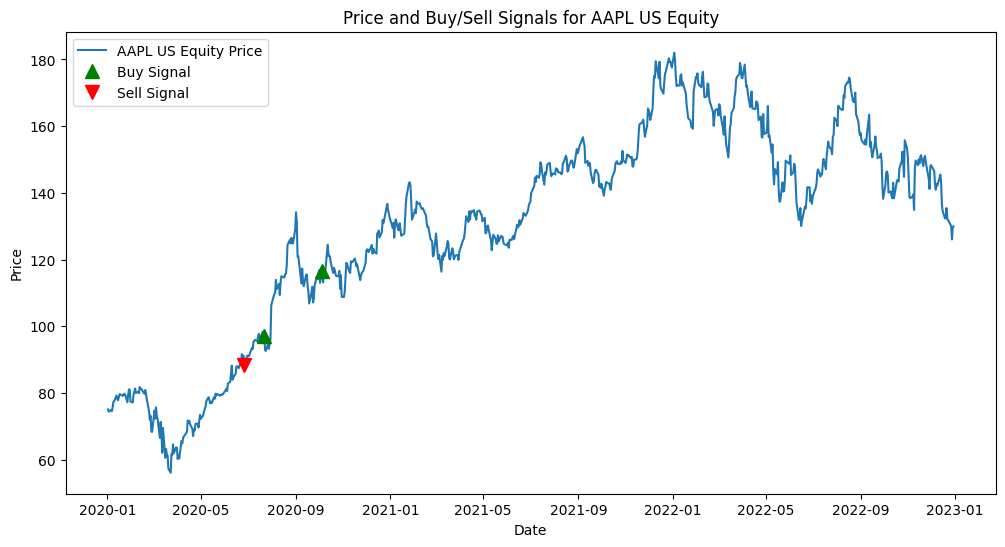

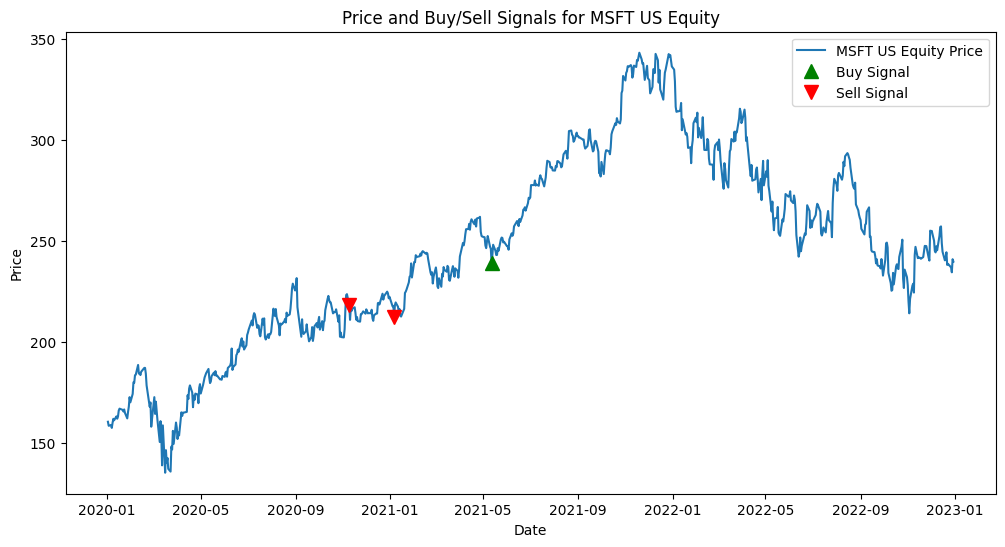

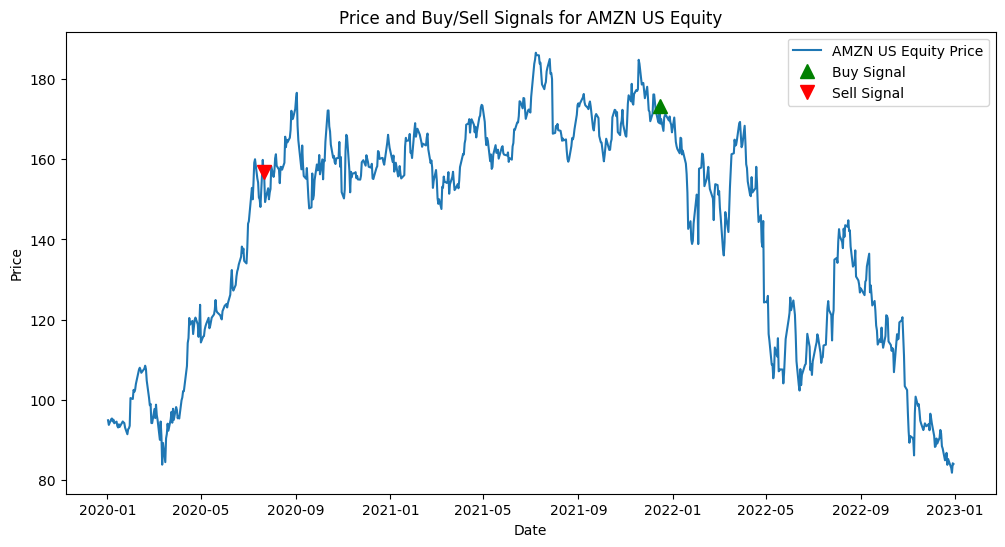

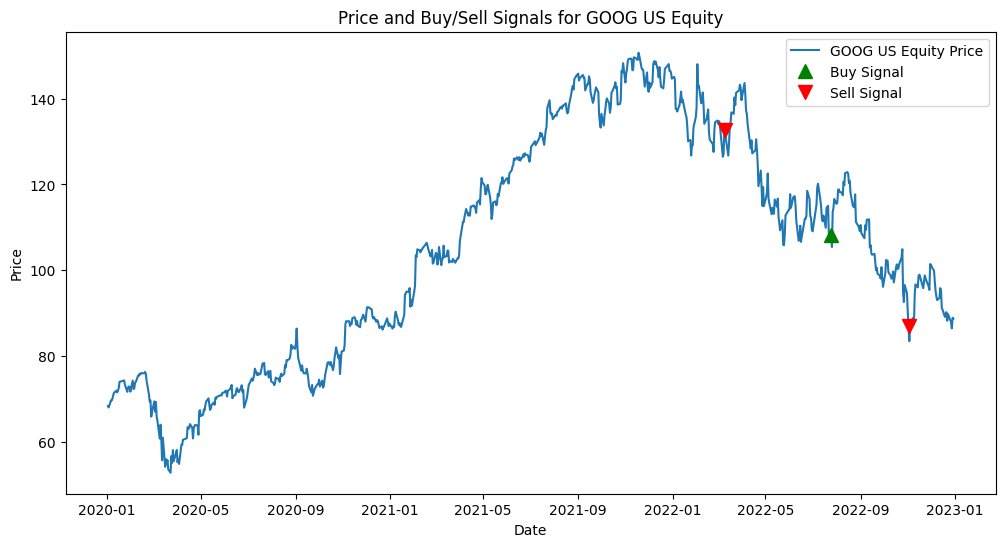

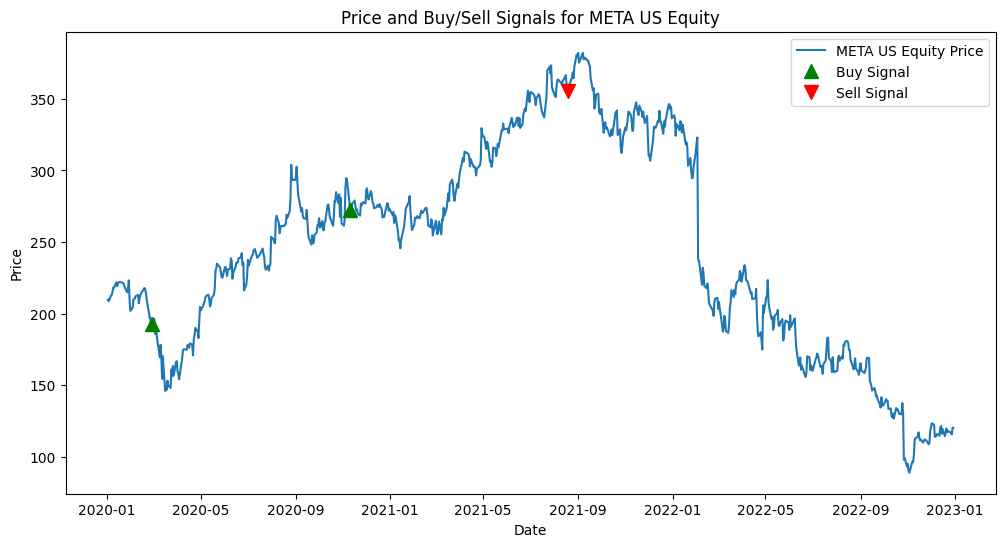

In [102]:
# Plot the price along with buy/sell signals
for ticker in tickers:
    ticker_data = data[data['Ticker'] == ticker]

    plt.figure(figsize=(12, 6))
    plt.plot(ticker_data['Date'], ticker_data['PX_LAST'], label=f'{ticker} Price')

    # Buy signals
    plt.plot(ticker_data[ticker_data['Position'] == 1]['Date'],
             ticker_data[ticker_data['Position'] == 1]['PX_LAST'],
             '^', markersize=10, color='g', label='Buy Signal')

    # Sell signals
    plt.plot(ticker_data[ticker_data['Position'] == -1]['Date'],
             ticker_data[ticker_data['Position'] == -1]['PX_LAST'],
             'v', markersize=10, color='r', label='Sell Signal')

    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'Price and Buy/Sell Signals for {ticker}')
    plt.legend()
    plt.show()


### Saving data

In [117]:

# List of tickers (you can add more as needed)
tickers = [
    'AAPL US Equity', 'MSFT US Equity', 'AMZN US Equity', 'GOOG US Equity', 'META US Equity', 
    'TSLA US Equity', 'NFLX US Equity', 'NVDA US Equity', 'BRK/B US Equity', 'V US Equity'
]

# Fetch historical data for the tickers (long time horizon)
data = blp.bdh(
    tickers=tickers, 
    flds=['PX_LAST'],  # You can add more fields here if needed (e.g., 'PX_VOLUME')
    start_date='2010-01-01',  # Long time horizon
    end_date='2023-01-01'     # Adjust the end date as needed
)

# Save the data to a CSV file (stacked format for easier analysis)
data.to_csv('bloomberg_stock_data.csv')

print("Data saved successfully to 'bloomberg_stock_data.csv'.")


Data saved successfully to 'bloomberg_stock_data.csv'.


### Fetching saved data

In [138]:

start_date = '2018-01-01'
end_date = '2023-01-01'

# Load the data
data = load_data(ticker, start_date, end_date, use_api)
data.head()

,AAPL US Equity,MSFT US Equity,AMZN US Equity,NFLX US Equity,NVDA US Equity,BRK/B US Equity,V US Equity
date,,,,,,,
2018-01-02,43.065,85.95,59.451,201.07,4.9838,197.22,114.51
2018-01-03,43.058,86.35,60.210,205.05,5.3118,199.79,115.65
2018-01-04,43.258,87.11,60.479,205.63,5.3398,200.69,116.08
2018-01-05,43.750,88.19,61.457,209.99,5.3850,201.42,118.86
2018-01-08,43.588,88.28,62.343,212.05,5.5500,202.74,119.34


### Fama-French 5 Factor Model

In [139]:
#pip install statsmodels

In [140]:
import statsmodels.api as sm

# Calculate stock returns for all stocks in the dataset
stock_returns = data.pct_change()

# Load Fama-French 5-Factor data (adjust the path as needed)
ff_factors = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv', skiprows=3)

# Rename the unnamed first column as 'Date'
ff_factors.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

# Drop any rows where 'Date' is NaN
ff_factors = ff_factors.dropna(subset=['Date'])

# Filter out non-date rows by keeping only rows where 'Date' is numeric
ff_factors = ff_factors[ff_factors['Date'].str.isnumeric()]

# Convert the 'Date' column to datetime format (YYYY-MM)
ff_factors['Date'] = pd.to_datetime(ff_factors['Date'], format='%Y%m')

# Convert all factor columns (Mkt-RF, SMB, HML, RMW, CMA, RF) to numeric to avoid string issues
factor_columns = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
ff_factors[factor_columns] = ff_factors[factor_columns].apply(pd.to_numeric, errors='coerce')

# Set the 'Date' column as the index
ff_factors = ff_factors.set_index('Date')

# Merge the stock returns with the Fama-French factors based on the date
combined_data = pd.merge(stock_returns, ff_factors, left_index=True, right_index=True, how='inner')


In [141]:
# Example: Calculate excess returns for a particular stock (e.g., 'AAPL US Equity')
combined_data['AAPL_Excess_Returns'] = combined_data['AAPL US Equity'] - combined_data['RF'] / 100

# Check the result
combined_data.head()

,AAPL US Equity,MSFT US Equity,AMZN US Equity,NFLX US Equity,NVDA US Equity,BRK/B US Equity,V US Equity,Mkt-RF,SMB,HML,RMW,CMA,RF,AAPL_Excess_Returns
2018-02-01,0.002078,-0.007894,-0.041974,-0.019349,-0.021562,0.013387,0.011994,-3.65,0.32,-1.04,0.48,-2.28,0.11,0.000978
2018-03-01,-0.017516,-0.009811,-0.012562,-0.003398,-0.040446,-0.027365,-0.020660,-2.35,3.60,-0.20,-0.42,-0.02,0.11,-0.018616
2018-05-01,0.023236,0.015825,0.010293,0.002688,0.009960,0.007123,0.004965,2.65,4.75,-3.22,-2.05,-1.53,0.14,0.021836
2018-06-01,0.018023,0.019729,0.007315,0.023692,0.021523,0.003655,0.000994,0.48,0.80,-2.33,0.80,0.20,0.14,0.016623
2018-08-01,0.058899,0.001885,0.011106,0.002756,0.006567,-0.000101,0.011043,3.44,0.65,-4.00,-0.31,-2.70,0.16,0.057299


In [142]:
# Define the independent variables (the Fama-French factors)
X = combined_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]

# Add a constant (intercept) to the independent variables
X = sm.add_constant(X)

# Define the dependent variable (excess returns for AAPL, for example)
Y = combined_data['AAPL_Excess_Returns']

# Run the Ordinary Least Squares (OLS) regression
model = sm.OLS(Y, X).fit()

# Output the regression results
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     AAPL_Excess_Returns   R-squared:                       0.074
Model:                             OLS   Adj. R-squared:                 -0.062
Method:                  Least Squares   F-statistic:                    0.5439
Date:                 Sun, 22 Sep 2024   Prob (F-statistic):              0.742
Time:                         23:55:11   Log-Likelihood:                 100.18
No. Observations:                   40   AIC:                            -188.4
Df Residuals:                       34   BIC:                            -178.2
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0082      0.004      2.21

In [143]:
# Example: Predict excess returns based on Fama-French factors
predicted_excess_returns = model.predict(X)

# Print a few predicted values
print(predicted_excess_returns.head())


2018-02-01    0.012342
2018-03-01    0.006967
2018-05-01    0.004731
2018-06-01    0.002360
2018-08-01    0.006361
dtype: float64


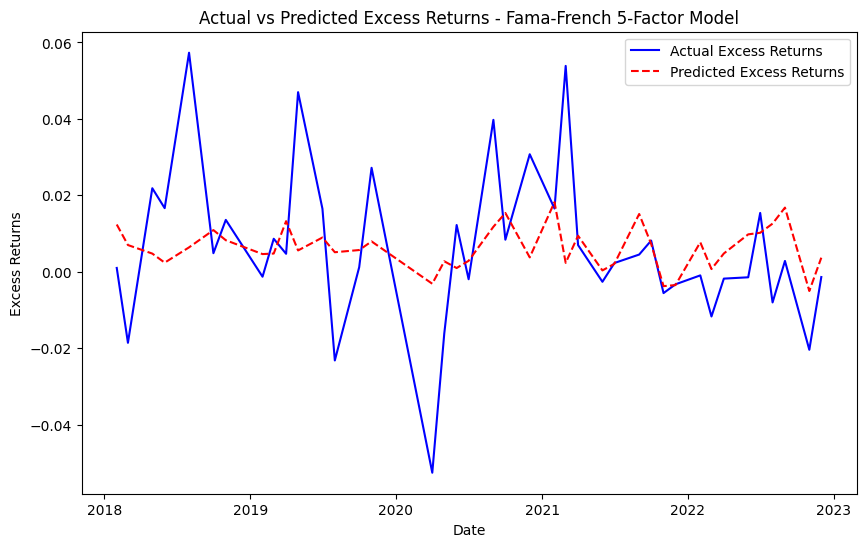

In [144]:
# Plot actual excess returns vs predicted excess returns
plt.figure(figsize=(10, 6))

# Plot actual excess returns
plt.plot(combined_data.index, combined_data['AAPL_Excess_Returns'], label='Actual Excess Returns', color='blue')

# Plot predicted excess returns from the model
plt.plot(combined_data.index, predicted_excess_returns, label='Predicted Excess Returns', linestyle='--', color='red')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Excess Returns')
plt.title('Actual vs Predicted Excess Returns - Fama-French 5-Factor Model')
plt.legend()

# Show the plot
plt.show()

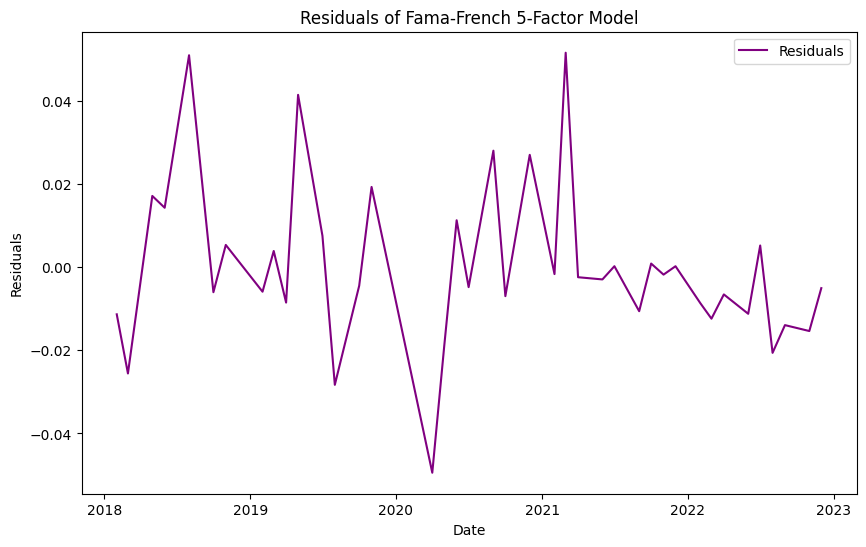

In [145]:
# Calculate the residuals (actual - predicted)
combined_data['Residuals'] = combined_data['AAPL_Excess_Returns'] - predicted_excess_returns

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(combined_data.index, combined_data['Residuals'], label='Residuals', color='purple')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals of Fama-French 5-Factor Model')
plt.legend()

# Show the plot
plt.show()

In [2]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Alexander\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [7]:
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# Simulate Stock Prices Using Geometric Brownian Motion (GBM)
def simulate_gbm(T, N, dt, mu, sigma, S0):
    W = np.random.randn(N, int(T/dt)) * np.sqrt(dt)  # Brownian motion increments
    S = np.zeros((N, int(T/dt)))
    S[:, 0] = S0
    for t in range(1, int(T/dt)):
        S[:, t] = S[:, t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * W[:, t-1])
    return S

# Policy network outputs allocation
class PolicyNet(torch.nn.Module):
    def __init__(self, d):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(2, 128)
        self.fc2 = torch.nn.Linear(128, d)
        
        # Log of diagonal elements to ensure positivity
        self.log_cov_diag = torch.nn.Parameter(torch.zeros(d))

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        mean = self.fc2(x)
        
        # Ensure covariance matrix is positive definite
        cov_diag = torch.exp(self.log_cov_diag)  # Use exp to ensure positive diagonal values
        cov_matrix = torch.diag(cov_diag)
        
        return mean, cov_matrix

# Value network to approximate the value of states
class ValueNet(torch.nn.Module):
    def __init__(self):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(2, 128)
        self.fc2 = torch.nn.Linear(128, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        value = self.fc2(x)
        return value

# Calculate portfolio return and variance
def compute_portfolio_metrics(weights, stock_returns):
    portfolio_return = np.dot(weights, stock_returns)
    portfolio_variance = np.dot(weights.T, np.dot(np.cov(stock_returns), weights))
    return portfolio_return, portfolio_variance

# Policy gradient update
def policy_gradient_step(policy_net, value_net, optimizer, states, actions, rewards):
    optimizer.zero_grad()

    # Compute policy loss
    mean, cov = policy_net(states)
    
    # Check for NaNs in mean or cov
    if torch.isnan(mean).any() or torch.isnan(cov).any():
        print("NaN in mean or covariance matrix")

    # Clamp values to avoid extreme values
    mean = torch.clamp(mean, -10, 10)
    cov = torch.clamp(cov, 1e-6, 1e6)  # Avoid too small or too large values in covariance

    dist = torch.distributions.MultivariateNormal(mean, cov)
    log_probs = dist.log_prob(actions)

    value = value_net(states)
    advantage = rewards - value

    loss = -(log_probs * advantage).mean()

    # Update parameters
    loss.backward()
    optimizer.step()

# Simulate a single episode of trading
def simulate_episode(policy_net, value_net, T, dt, num_assets, stock_prices, initial_wealth, gamma):
    wealth = initial_wealth
    states = []
    actions = []
    rewards = []
    
    for t in range(0, int(T/dt)):
        current_time = t * dt
        stock_returns = stock_prices[:, t + 1] / stock_prices[:, t] - 1  # Compute stock returns
        state = torch.tensor([wealth, current_time], dtype=torch.float32)
        
        # Get action (allocation) from the policy network
        mean, cov = policy_net(state)
        dist = torch.distributions.MultivariateNormal(mean, cov)
        action = dist.sample().numpy()
        
        # Compute portfolio metrics (return and variance)
        portfolio_return, portfolio_variance = compute_portfolio_metrics(action, stock_returns)
        
        # Update wealth based on portfolio return
        wealth = wealth * (1 + portfolio_return)
        
        # Reward is the return adjusted for variance (e.g., Sharpe ratio-like metric)
        reward = portfolio_return - gamma * portfolio_variance
        
        # Store state, action, and reward
        states.append(state)
        actions.append(torch.tensor(action, dtype=torch.float32))
        rewards.append(torch.tensor(reward, dtype=torch.float32))
    
    return states, actions, rewards

# Training loop
def train(policy_net, value_net, T, dt, num_assets, num_episodes, gamma, initial_wealth):
    policy_optimizer = optim.Adam(policy_net.parameters(), lr=0.001)  # Lower learning rate to avoid instability
    value_optimizer = optim.Adam(value_net.parameters(), lr=0.001)

    for episode in range(num_episodes):
        # Simulate stock prices
        stock_prices = simulate_gbm(T, num_assets, dt, mu=0.05, sigma=0.2, S0=100)
        
        # Simulate an episode and get states, actions, and rewards
        states, actions, rewards = simulate_episode(policy_net, value_net, T, dt, num_assets, stock_prices, initial_wealth, gamma)
        
        # Convert lists to tensors
        states = torch.stack(states)
        actions = torch.stack(actions)
        rewards = torch.stack(rewards)
        
        # Perform policy gradient update
        policy_gradient_step(policy_net, value_net, policy_optimizer, states, actions, rewards)

# Parameters
T = 1.0  # 1 year of trading
dt = 1/252  # daily time steps
num_assets = 5  # Number of stocks
initial_wealth = 100000  # Initial wealth in the portfolio
gamma = 0.01  # Risk aversion parameter
num_episodes = 1000  # Number of training episodes

# Initialize policy and value networks
policy_net = PolicyNet(num_assets)
value_net = ValueNet()

# Train the model
train(policy_net, value_net, T, dt, num_assets, num_episodes, gamma, initial_wealth)

# Plot some results (e.g., stock prices)
stock_prices = simulate_gbm(T, num_assets, dt, mu=0.05, sigma=0.2, S0=100)
plt.plot(np.linspace(0, T, int(T/dt)), stock_prices.T)
plt.title('Simulated Stock Prices')
plt.show()


ValueError: Expected parameter loc (Tensor of shape (5,)) of distribution MultivariateNormal(loc: torch.Size([5]), covariance_matrix: torch.Size([5, 5])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([nan, nan, nan, nan, nan], grad_fn=<ExpandBackward0>)